# scRNA Analysis Preprocessing Workflow

**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)


This notebook demonstrates a complete end-to-end single cell analysis workflow. It starts with loading the dataset with over 200k cells from the [CELLxGENE data repository](https://cellxgene.cziscience.com/e/ae29ebd0-1973-40a4-a6af-d15a5f77a80f.cxg/). We will use [AnnData](https://anndata.readthedocs.io/en/stable/) to load the dataset into Python, [scanpy](https://scanpy.readthedocs.io/en/stable/) for plotting, and [RAPIDS-singlecell](https://rapids-singlecell.readthedocs.io/en/latest/) to run data processing on the GPU. The workflow for the labs is as follows:

1. Data loading
2. Data pre-processing
    1. Quality Control (QC) to visually understand the data
    2. Filtering unusual cells
    3. Normalization to removing unwanted variation
3. Clustering and visualization:
    1. PCA
    2. Nearest Neighbors and UMAP
    3. Louvain and Leiden Clustering
    4. Batch Correction
    5. t-SNE
    6. Differential expression analysis
    7. Diffusion Map Embedding

**Let's begin!**

In [ ]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/opt/conda/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/opt/conda/lib/python3.13/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


Before we begin, we must set up the RAPIDS Memory Manager, which will determine how the dataset is stored in VRAM. We can choose either `managed_memory` (if the dataset does not fit into VRAM) or `pool_allocator` (if the dataset does fit into VRAM). Since the dataset for this notebook is small, it should fit inside the VRAM of most GPUs, so we will set `pool_allocator=True` and `managed_memory=False`. Only one option can be set true at a time, not both. For more information on the difference between these two options, see the [RAPIDS docs](https://rapids-singlecell.readthedocs.io/en/latest/MM.html#memory-management).

In [ ]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Data Loading

In this lab, we will use a single cell dataset that can be found in the [CELLxGENE](https://cellxgene.cziscience.com/e/ae29ebd0-1973-40a4-a6af-d15a5f77a80f.cxg/) data repository. It contains over 200k cells and 60k genes taken from immune cells across multiple tissue types.

In [ ]:
import os
import anndata as ad
import wget

url = 'https://scverse-exampledata.s3.eu-west-1.amazonaws.com/rapids-singlecell/dli_census.h5ad'
data_dir = "./h5"
output = data_dir+'/dli_census.h5ad'
if not os.path.exists(data_dir): # Check if h5 directory exists
    print('creating data directory')
    os.system('mkdir ./h5')
else:
    print(f'{data_dir} directory found')

if not os.path.isfile(output): # Check to see if we have our final output.  If it is there, get to the analysis!
    if not os.path.isfile(output): # as it's not there, let's see if we have our downloaded file.  If not, let's get it!
        print('Downloading cell data..')
        wget.download(url, output)

    adata = ad.read_h5ad(output)
    adata= adata[adata.obs["assay"].isin(["10x 3' v3", "10x 5' v1", "10x 5' v2"])].copy()
    adata.write(output)
else:
    print(f'{output} dataset found')

./h5 directory found
./h5/dli_census.h5ad dataset found


Load the `h5ad` file containing the sparse count matrix into an AnnData object. See the [AnnData documentation](https://anndata.readthedocs.io/en/stable/) for more information on this data format.

In [ ]:
adata = sc.read(output)

CPU times: user 353 ms, sys: 837 ms, total: 1.19 s
Wall time: 1.19 s


By default, this data object is loading onto the CPU. We will use RAPIDS-singlecell to move the AnnData object to the GPU.

In [ ]:
rsc.get.anndata_to_GPU(adata)

CPU times: user 115 ms, sys: 784 ms, total: 899 ms
Wall time: 897 ms


Note the initial size of the dataset

In [ ]:
adata.shape

## Data Preprocessing

As a prerequisite for downstream analysis, it will help if the variable names

In [ ]:
adata.var_names = adata.var.feature_name.astype(str).to_numpy()

### Quality Control

We calculate quality control (QC) metrics to assess cell and gene quality. These include:  

- **Per cell metrics**:  
  - Total counts per cell (library size)  
  - Number of detected genes per cell  
  - Percentage of counts from mitochondrial (`MT`) and ribosomal (`RIBO`) genes  

- **Per gene metrics** (gene space):  
  - Total counts per gene  
  - Number of cells expressing each gene  

These metrics help identify low-quality or stressed cells and ensure a meaningful feature set for downstream analysis.

To count the mitochondrial (MT) and ribosomal (RIBO) genes, we must first flag which genes belong to these groups. This can be done by creating a boolean column with the name set by `gene_family_name` where the value is true for any genes with the prefix set by `gene_family_prefix`. This column will be added in place. For more information see the docs for [`rsc.pp.flag_gene_family`](https://rapids-singlecell.readthedocs.io/en/latest/api/generated/rapids_singlecell.pp.flag_gene_family.html#rapids_singlecell.pp.flag_gene_family).

In [ ]:
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 2.78 ms, sys: 0 ns, total: 2.78 ms
Wall time: 2.57 ms


In [ ]:
rsc.pp.flag_gene_family(adata, gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 2.14 ms, sys: 89 μs, total: 2.23 ms
Wall time: 2.21 ms


Lastly, we can calculate the QC metrics needed for visualization by passing in our new column names to the [`rsc.pp.calculate_qc_metrics`](https://rapids-singlecell.readthedocs.io/en/latest/api/generated/rapids_singlecell.pp.calculate_qc_metrics.html) function.

In [ ]:
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO"])

CPU times: user 453 ms, sys: 24.4 ms, total: 477 ms
Wall time: 556 ms


To visualize the quality control (QC) metrics, we generate the following plots:

1. **Scatter plot: Total counts vs. Mitochondrial percentage**  
   - This plot shows the relationship between the total UMI counts per cell and the percentage of mitochondrial (`MT`) gene expression.  
   - Cells with high mitochondrial percentages may indicate stressed or dying cells.

2. **Scatter plot: Total counts vs. Number of detected genes**  
   - This plot displays the correlation between the total UMI counts per cell and the number of detected genes.  
   - A strong correlation is expected, but outliers with low gene counts might indicate empty droplets or dead cells.

3. **Violin plot: Number of detected genes per cell**  
   - This violin plot visualizes the distribution of the number of detected genes per cell.  
   - It helps identify cells with abnormally low or high gene counts, which could be filtered out.

4. **Violin plot: Total counts per cell**  
   - This plot shows the distribution of total counts per cell, indicating library size variation.  
   - Extreme values may suggest low-quality or overly dominant cells.

5. **Violin plot: Percentage of mitochondrial counts per cell**  
   - This plot illustrates the distribution of mitochondrial gene expression across all cells.  
   - High mitochondrial content could be a sign of cell stress or apoptosis.

These visualizations help assess dataset quality and guide decisions on filtering low-quality cells.

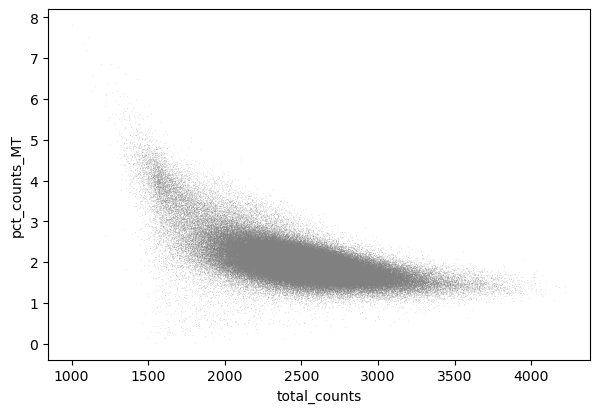

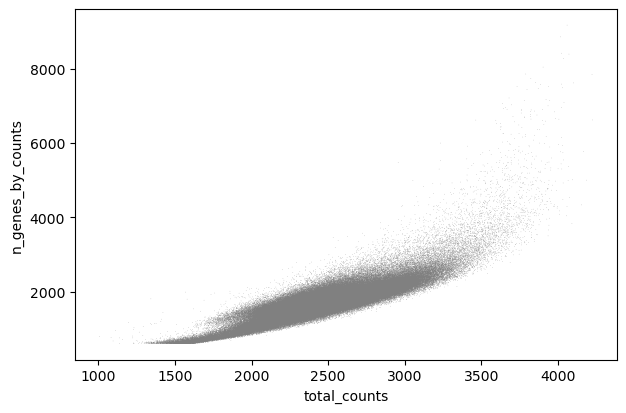

In [ ]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

### Filtering

When gene counts (`n_genes_by_counts`) are too large or the percentage of mitochondrial dna (`pct_counts_MT`) is too high, it can be indicative of low quality cells which can be filtered out of the dataset. The cut-offs are determined by visual inspection of the scatter plots.

In [ ]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["pct_counts_MT"] < 20]

CPU times: user 433 ms, sys: 107 ms, total: 540 ms
Wall time: 539 ms


We also filter out genes that are expressed in less than 3 cells, as they will not provide much information.

In [ ]:
%%time
rsc.pp.filter_genes(adata, min_cells=3)

filtered out 8265 genes that are detected in less than 3 cells
CPU times: user 2.09 s, sys: 316 ms, total: 2.41 s
Wall time: 2.88 s


The size of our count matrix is now reduced.

In [ ]:
adata.shape

(216382, 28133)

### Normalization

We normalize the count matrix so that the total counts in each cell sum to 1e4 using a [shifted logarithm](https://www.sc-best-practices.org/preprocessing_visualization/normalization.html#shifted-logarithm). This will help remove some technical variability due to sequencing depth.

In [ ]:
rsc.pp.normalize_total(adata, target_sum=1e4)
rsc.pp.log1p(adata)

CPU times: user 31.1 ms, sys: 23 μs, total: 31.1 ms
Wall time: 31.1 ms


**Select Most Variable Genes**

We now search for highly variable genes, which help focus our analysis on the most informative genes while improving computational efficiency. This function supports the flavors `cell_ranger`, `seurat`, `seurat_v3`, and `pearson_residuals`.  
As in Scanpy, you can either filter based on variance cutoffs or select the `n_top_genes`. Additionally, you can use a `batch_key` to correct for batch effects.  

In this example, we use the `cell_ranger` method, which selects highly variable genes based on the log-normalized counts stored in `.X`.


In [ ]:
rsc.pp.highly_variable_genes(adata, n_top_genes=5000, flavor="cell_ranger")

CPU times: user 318 ms, sys: 10.2 ms, total: 328 ms
Wall time: 350 ms


Now we save this version of the AnnData as adata.raw.

In [ ]:
adata.raw = adata

CPU times: user 1.69 ms, sys: 132 ms, total: 134 ms
Wall time: 183 ms


We now restrict our AnnData object to only the highly variable genes.  
This step reduces the number of features, focusing the analysis on the most informative genes while improving computational efficiency.

In [ ]:
rsc.pp.filter_highly_variable(adata)

CPU times: user 302 ms, sys: 121 ms, total: 422 ms
Wall time: 742 ms


Next, we regress out the effects of total counts per cell and mitochondrial content.  
This helps remove technical variation that could bias downstream analyses.  

As in Scanpy, you can regress out any numerical column from `.obs`, allowing for the correction of batch effects, sequencing depth, or other confounding factors.

For more complex data sets, these steps may overcorrect and remove potentially useful information and need to be carefully used.

In [ ]:
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 788 ms, sys: 141 ms, total: 929 ms
Wall time: 1.6 s


**Scale**

Finally, we scale the count matrix to obtain a z-score transformation, standardizing gene expression across cells.  
To prevent extreme values from dominating the analysis, we apply a cutoff of 10 standard deviations.  
This ensures that highly expressed genes do not disproportionately influence downstream computations.

In [ ]:
rsc.pp.scale(adata, max_value=10)

CPU times: user 1.12 s, sys: 189 ms, total: 1.31 s
Wall time: 1.71 s


Now we move `.X` out of the GPU.

In [ ]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 12.143767356872559


## Clustering and Visualization

### Principal component analysis

We use Principal Component Analysis (PCA) to reduce the dimensionality of the gene expression matrix to its top 100 principal components.  
This step captures the most important sources of variation in the data while reducing computational complexity.  

We use the GPU-accelerated PCA implementation from cuML, which significantly speeds up computation compared to CPU-based methods.

In [ ]:
rsc.tl.pca(adata, n_comps=100)

CPU times: user 618 ms, sys: 330 ms, total: 948 ms
Wall time: 4.19 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

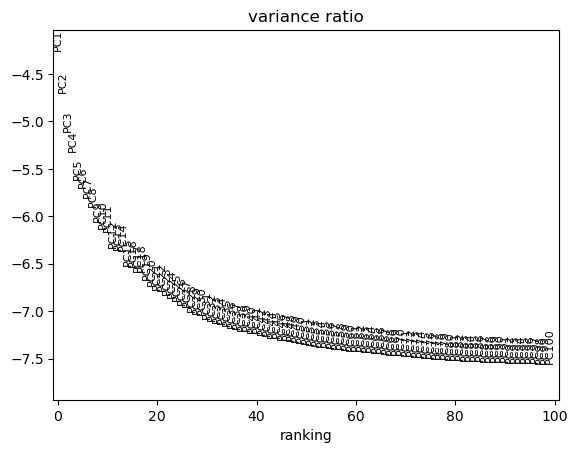

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now, we transfer the `.X` matrix back to host (CPU) memory to free up GPU resources.  

Since some downstream analyses or visualizations may not require GPU acceleration, this step helps optimize memory usage,  
preventing unnecessary GPU load while still keeping the processed data accessible for further analysis.

In [ ]:
rsc.get.anndata_to_CPU(adata)

### Nearest Neighbors and UMAP

Next, we compute the neighborhood graph using `rsc`.  

Scanpy’s CPU-based implementation of nearest neighbor search uses an approximation, while the GPU-accelerated RAPIDS implementation computes the exact graph.  
Both methods are valid, but small differences in results can occur.  

The following approximate nearest neighbor (ANN) algorithms are also supported:  
- **`ivfflat`**: Uses an inverted file index for fast approximate search, suitable for very large datasets.  
- **`ivfpq`**: A variant of `ivfflat` that compresses data for even more efficient memory usage, trading off some accuracy.  
- **`cagra`**: A graph-based ANN method optimized for fast, high-accuracy queries on GPUs.  
- **`nn_descent`**: A graph-based method that incrementally refines the nearest neighbor search and works well for large, high-dimensional datasets.  

Since our dataset is relatively small, we use **brute-force (`brute`)** search to ensure exact results.

In [ ]:
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 2.02 s, sys: 853 ms, total: 2.88 s
Wall time: 3.14 s


Next, we calculate the UMAP embedding using RAPIDS.  

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that preserves local and global structure in the data.  
The RAPIDS implementation accelerates UMAP computation on GPUs, making it significantly faster than the standard CPU version.

In [ ]:
rsc.tl.umap(adata)

CPU times: user 448 ms, sys: 190 ms, total: 638 ms
Wall time: 1.95 s


### Louvain and Leiden Clustering

Next, we use the **Louvain** and **Leiden** algorithms for graph-based clustering with RAPIDS.  

Both methods detect communities (clusters) in the neighborhood graph by optimizing modularity:  
- **Louvain**: A hierarchical clustering algorithm that iteratively refines clusters for optimal modularity.  
- **Leiden**: An improved version of Louvain that guarantees well-connected, more stable clusters.  

Using RAPIDS accelerates the clustering process on GPUs, making it significantly faster than traditional CPU implementations.

In [ ]:
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 765 ms, sys: 372 ms, total: 1.14 s
Wall time: 2.81 s


In [ ]:
rsc.tl.leiden(adata, resolution=0.6)

CPU times: user 511 ms, sys: 189 ms, total: 700 ms
Wall time: 2.16 s


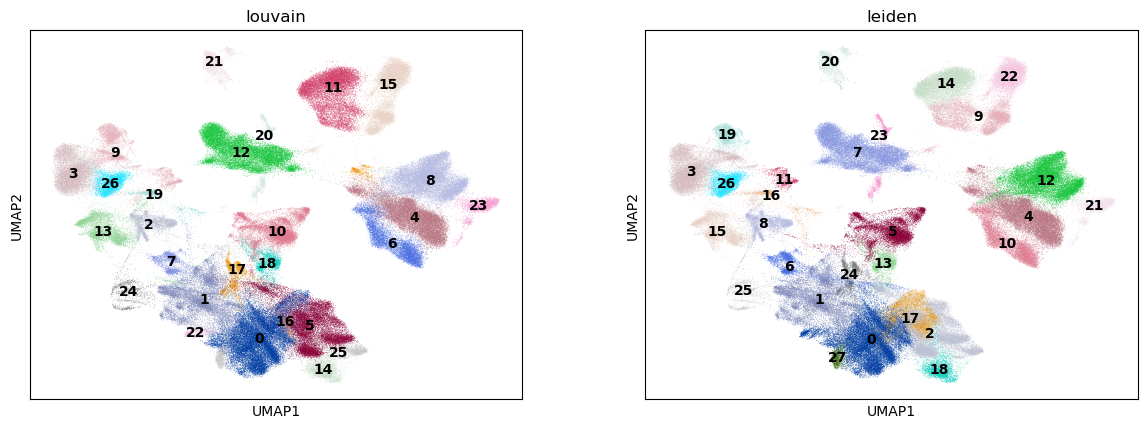

CPU times: user 1.04 s, sys: 13.9 ms, total: 1.05 s
Wall time: 1.05 s


In [ ]:
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

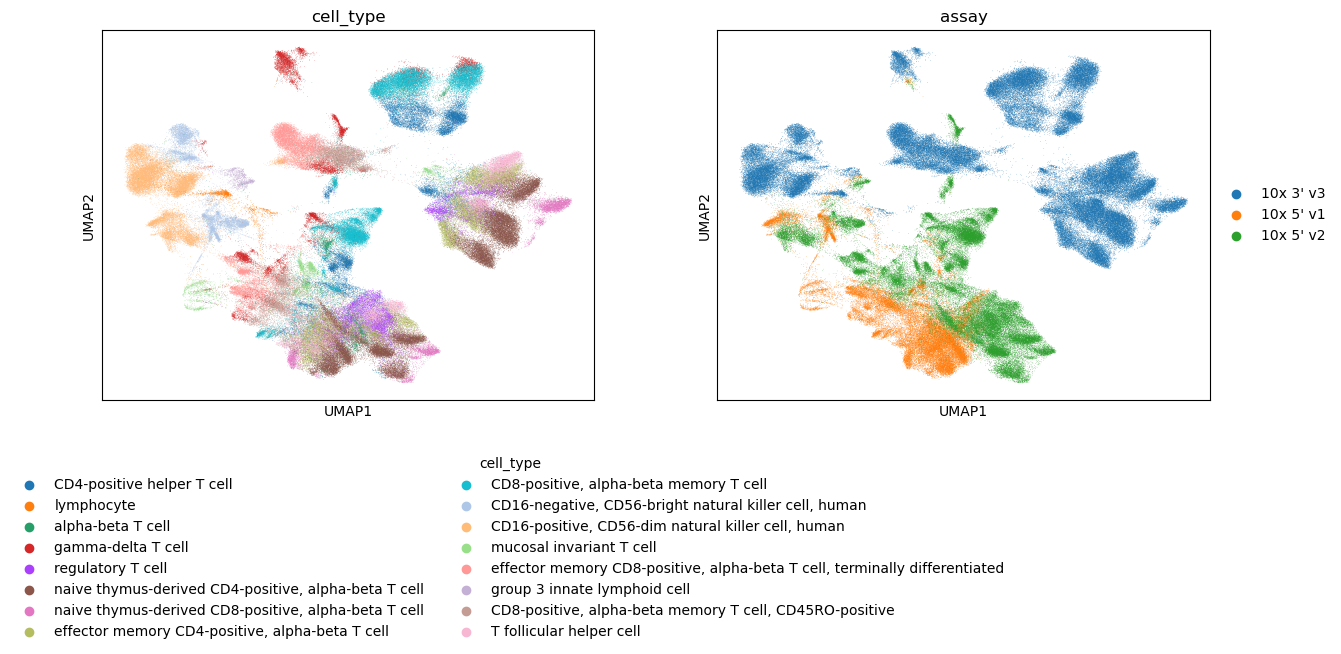

In [ ]:
fig = sc.pl.umap(adata, color=["cell_type", "assay"], return_fig=True)
ax = fig.axes[0]
ax.legend_.set_title("cell_type")
ax.legend_.set_bbox_to_anchor((-0.2, -0.4))


### Batch Correction  

In the previous UMAP, we observed strong batch effects between assay types.  
To correct for this, we apply **Harmony**, a method that aligns different batches while preserving biological variation.  

After applying Harmony, we will redo:  
- **Neighborhood search** to recompute the k-nearest neighbor graph  
- **UMAP** to visualize the corrected embedding  
- **Graph-based clustering** to identify cell populations without batch-driven artifacts  

This ensures that batch effects do not drive clustering results while retaining meaningful biological structure.


In [ ]:
rsc.pp.harmony_integrate(adata, key="assay", dtype=cp.float32)

CPU times: user 5.15 s, sys: 856 ms, total: 6 s
Wall time: 8.85 s


In [ ]:
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40,use_rep="X_pca_harmony",key_added="harmony")
rsc.tl.umap(adata,neighbors_key="harmony",key_added="X_umap_harmony")
rsc.tl.louvain(adata, resolution=0.6,neighbors_key="harmony",key_added="louvain_harmony")
rsc.tl.leiden(adata, resolution=0.6,neighbors_key="harmony",key_added="leiden_harmony")

CPU times: user 1.96 s, sys: 1.16 s, total: 3.12 s
Wall time: 7.84 s


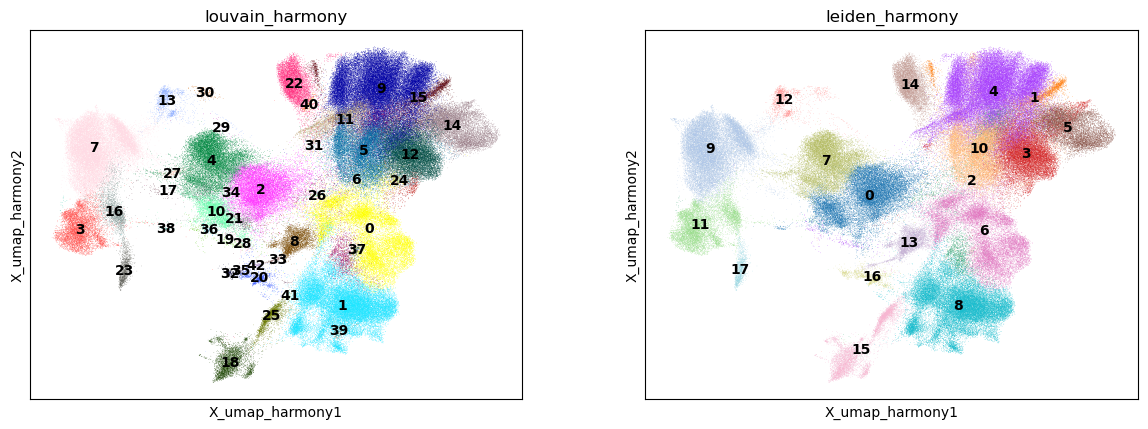

CPU times: user 1.07 s, sys: 5.37 ms, total: 1.07 s
Wall time: 1.07 s


In [ ]:
sc.pl.embedding(adata,basis="X_umap_harmony", color=["louvain_harmony", "leiden_harmony"], legend_loc="on data")

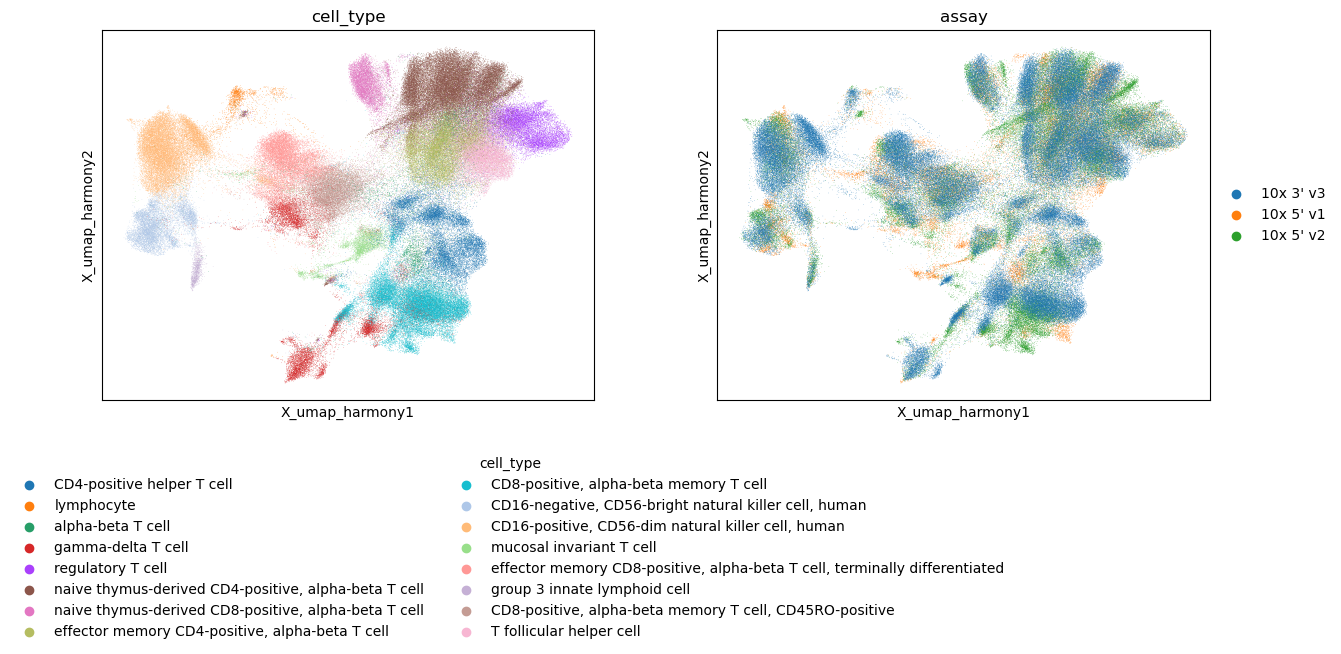

In [ ]:
fig = sc.pl.embedding(adata,basis="X_umap_harmony", color=["cell_type", "assay"], return_fig=True)
ax = fig.axes[0]
ax.legend_.set_title("cell_type")
ax.legend_.set_bbox_to_anchor((-0.2, -0.4))

### t-SNE

Next, we use **t-distributed Stochastic Neighbor Embedding (t-SNE)** to visualize cells in two dimensions.  
t-SNE is a non-linear dimensionality reduction technique that preserves local structure and reveals complex patterns in the data.  

We leverage the RAPIDS GPU implementation of t-SNE, which is significantly faster than CPU-based methods.  
This allows us to efficiently process large datasets while maintaining high-quality embeddings.  



In [ ]:
rsc.tl.tsne(adata, n_pcs=40, perplexity=30, early_exaggeration=12, learning_rate=200, use_rep="X_pca_harmony")

[2025-12-04 23:31:40.093] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 3.1 s, sys: 4.84 s, total: 7.95 s
Wall time: 11.5 s


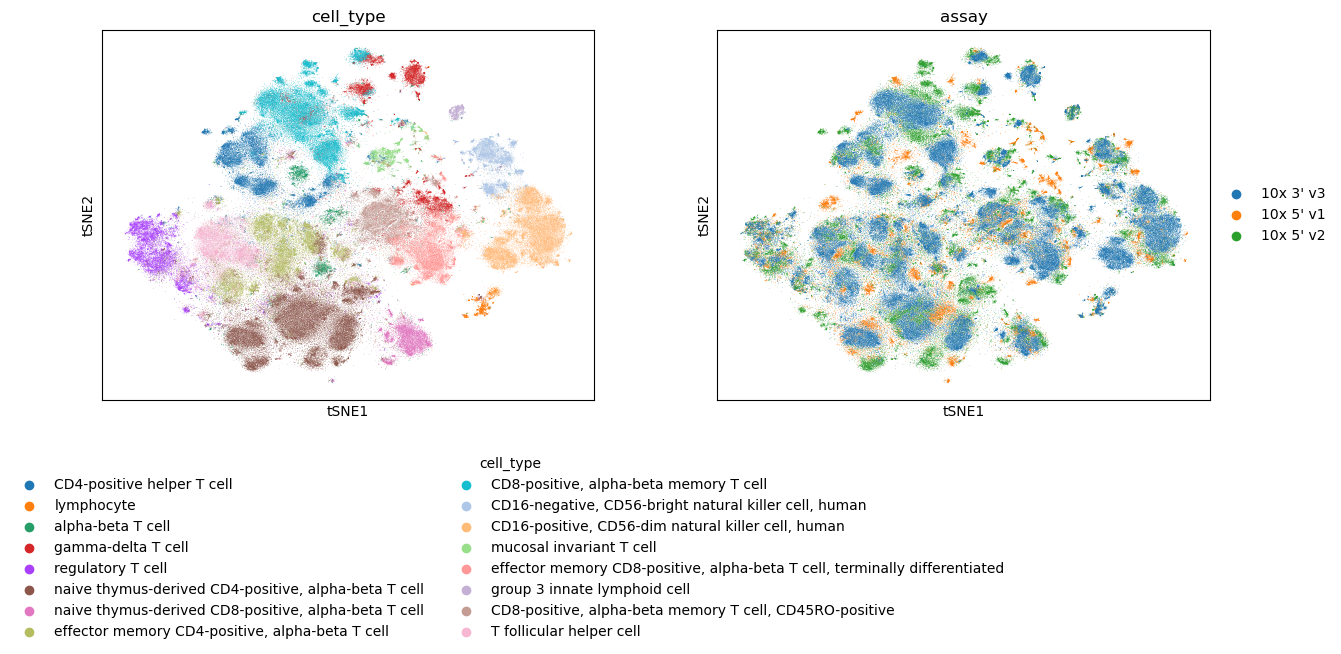

In [ ]:
fig = sc.pl.tsne(adata, color=["cell_type", "assay"], return_fig=True)
ax = fig.axes[0]
ax.legend_.set_title("cell_type")
ax.legend_.set_bbox_to_anchor((-0.2, -0.4))

### Differential expression analysis

To identify key marker genes for each cell type, we use **logistic regression** to compute a ranking of highly differential genes.  
Unlike traditional statistical tests, logistic regression models the probability of a gene being highly expressed in a given cluster  
while accounting for all genes simultaneously, making it more robust for complex datasets.  

We rank the top 50 genes that best distinguish each **cell type**, helping to characterize biological differences between clusters.  

In [ ]:
rsc.tl.rank_genes_groups_logreg(adata, groupby="cell_type", use_raw=False)

CPU times: user 16.4 s, sys: 14.9 s, total: 31.3 s
Wall time: 49.3 s


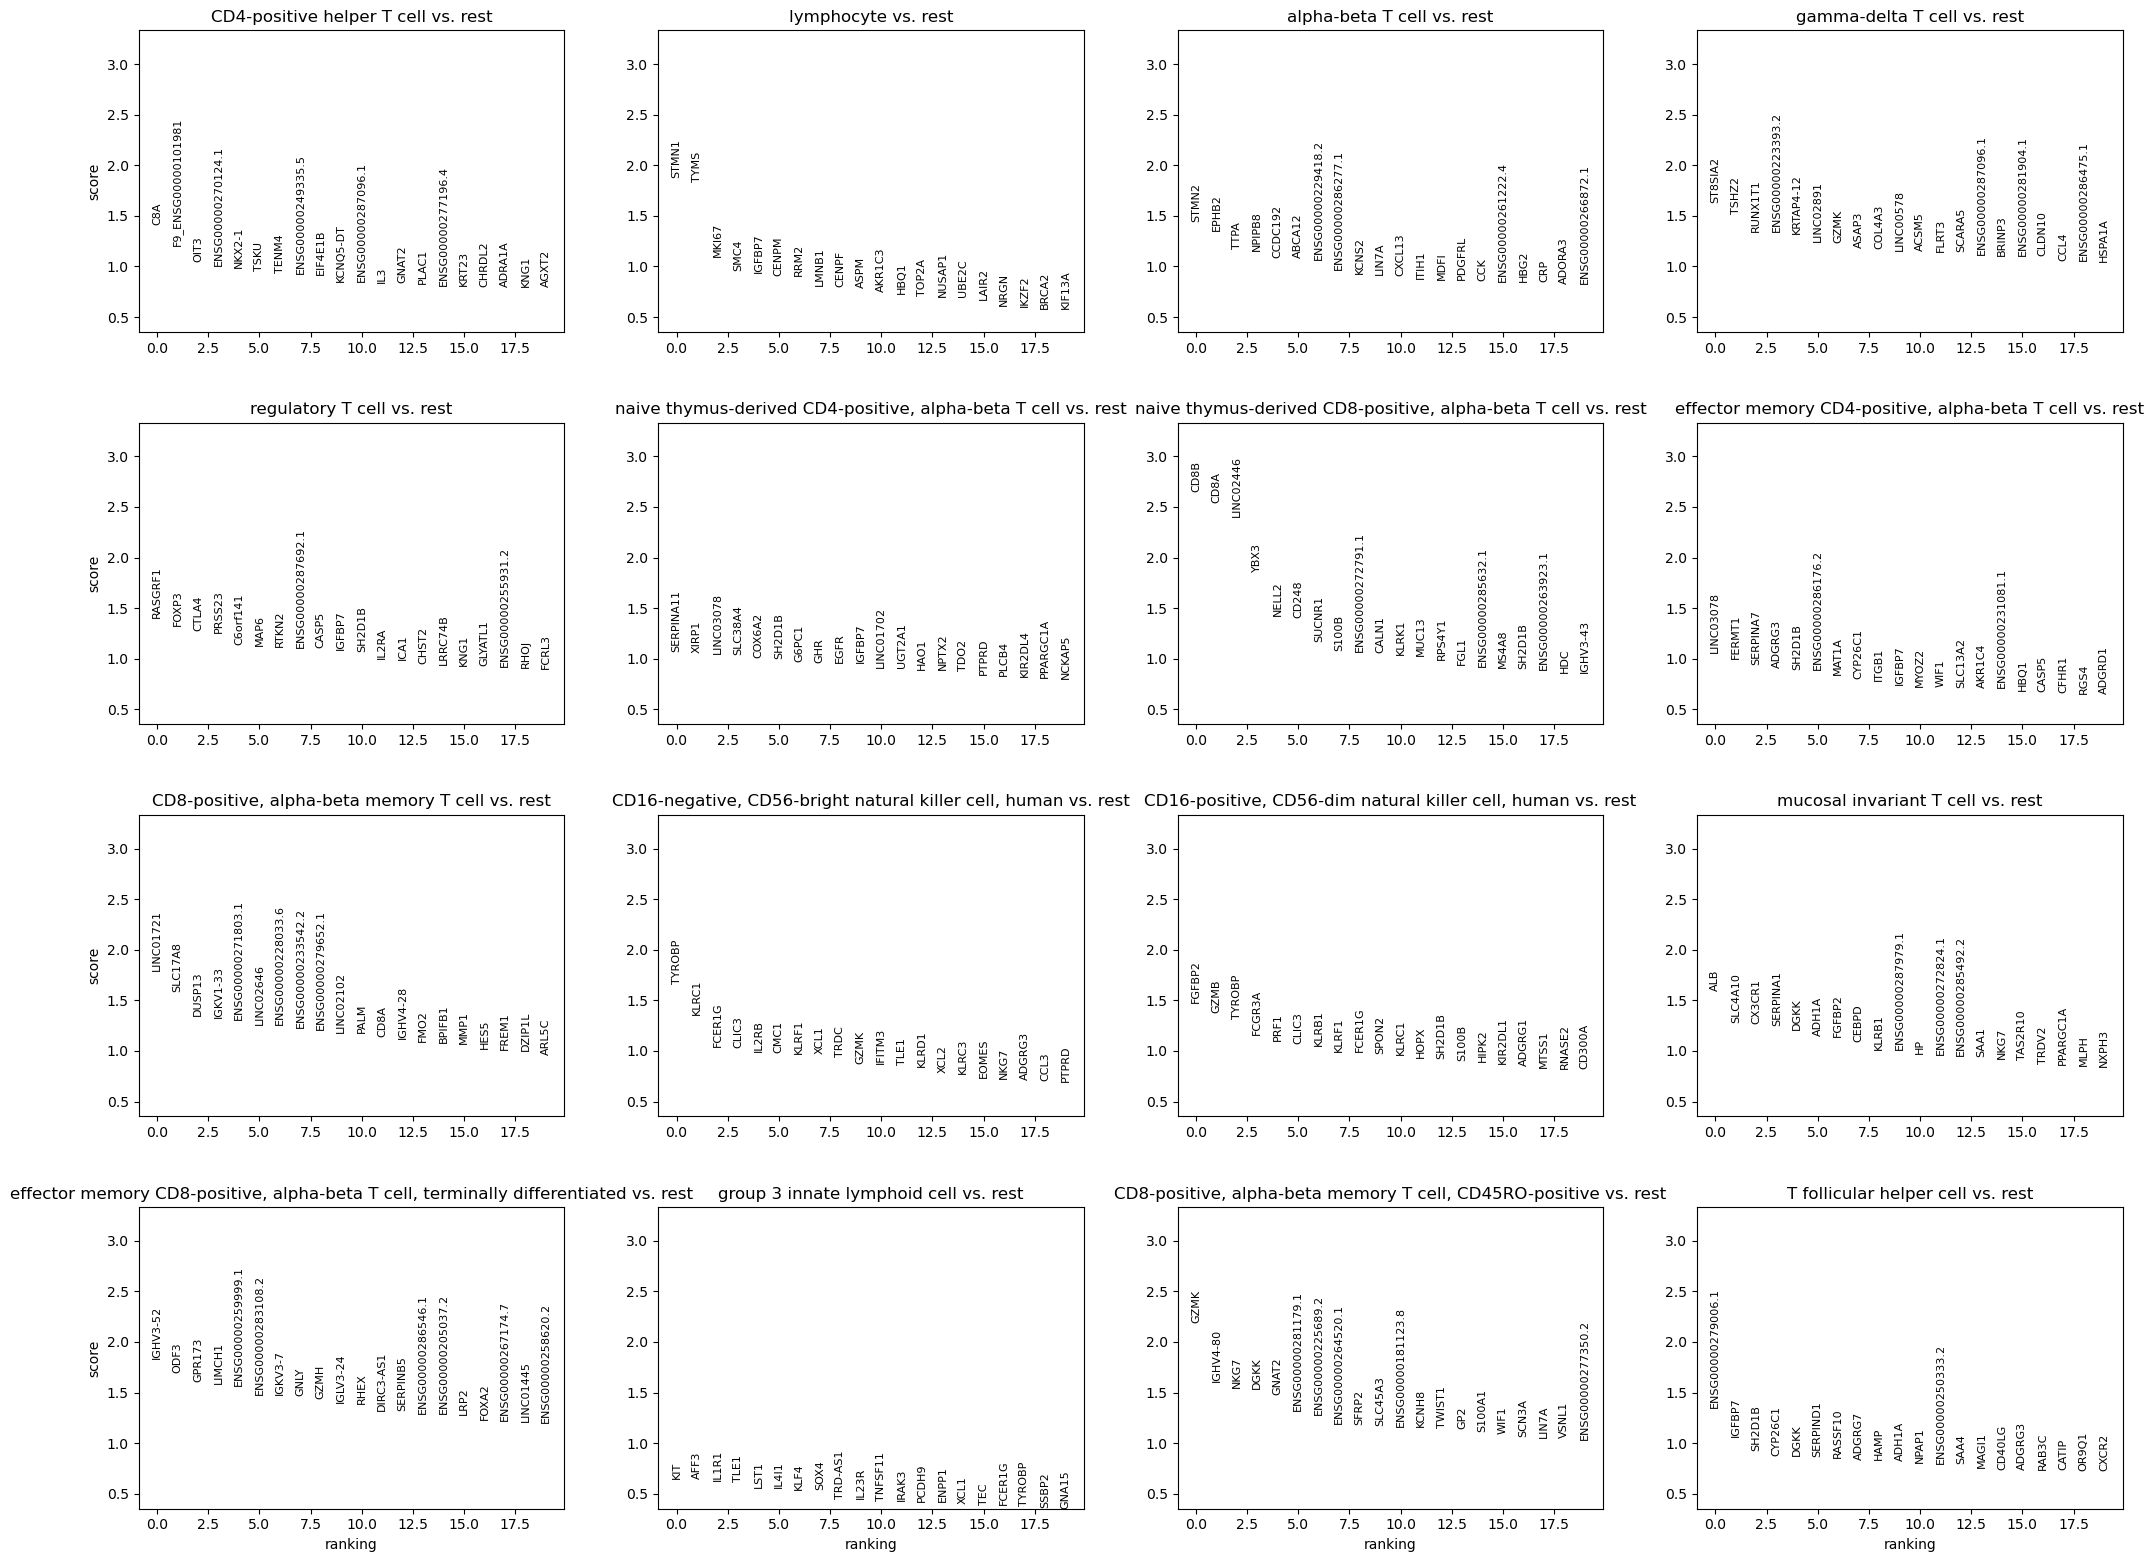

In [ ]:
sc.pl.rank_genes_groups(adata)

### Diffusion Map Embedding  

Next, we compute **Diffusion Maps**, a nonlinear dimensionality reduction method that preserves the continuous structure of the data.  
Unlike UMAP and t-SNE, Diffusion Maps are well-suited for capturing **trajectory-like** relationships in single-cell data.  

We use the batch-corrected neighborhood graph (`neighbors_key="harmony"`) to ensure that the embedding is not influenced by batch effects.  

In [ ]:
rsc.tl.diffmap(adata,neighbors_key="harmony")
#Due to an issue with plotting in Scanpy, we need to shift the first component of the diffusion map by removing the first column:
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:]

CPU times: user 2.4 s, sys: 165 ms, total: 2.57 s
Wall time: 3.35 s


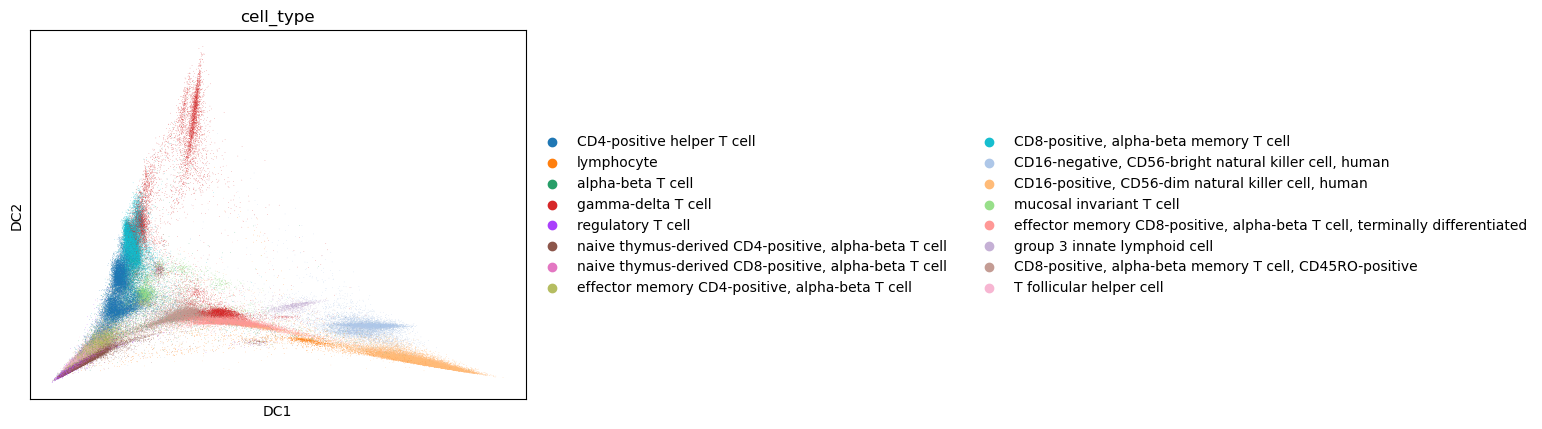

In [ ]:
sc.pl.diffmap(adata, color="cell_type")

Let's store this final output, which will be needed for the next notebooks in this series.

In [ ]:
adata.write("h5/dli_decoupler.h5ad")

## Conclusion

And with that, we have completed the entire end-to-end workflow for single-cell analysis. From data loading and filtering to clustering and visualization. Thanks to the speed of RAPIDS-singlecell we were able to run nearly every cell in real time, allowing us to iterate faster and tackle larger and larger datasets.

## Next Steps

We can now take this output file, `dli_decoupler.h5ad`, and use it further analysis, like **[Transcriptional Regulatory Analysis](https://github.com/NVIDIA-AI-Blueprints/single-cell-analysis-blueprint/blob/main/notebooks/02_scRNA_analysis_extended.ipynb)**.  You can quickly download the notebook and continue your journey by uncommenting and running the command below:

In [ ]:
# !wget https://raw.githubusercontent.com/NVIDIA-AI-Blueprints/single-cell-analysis-blueprint/refs/heads/main/notebooks/02_scRNA_analysis_extended.ipynb